In [ ]:
  # mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_path = '/content/gdrive/My Drive/KULIAH SEMESTER 8/KODING PENELITIAN SKRIPSI/'

In [ ]:
import sys
sys.path.append(root_path)
sys.path.append(root_path + 'sastrawi_installation')

In [ ]:
import pandas as pd

df = pd.read_csv(root_path + 'cleaning_dataset_autolabelling_indobert_review_jogjakita.csv')
df['cleaning'] = df['cleaning'].astype('str')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# meload model word2vec
from gensim.models import word2vec, Word2Vec

if 'model_cbow' not in locals():
  model_cbow = Word2Vec.load(root_path + 'MODEL WORD2VEC/idwiki_word2vec_300_new_lower_plus_jogjakita_corpus_CBOW.model')

In [ ]:

# mengetahui jumlah kalimat terpanjang
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaning'])
input_sequences = tokenizer.texts_to_sequences(df['cleaning'])
max_sequence_length = max(len(seq) for seq in input_sequences)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Menambahkan token <PAD> pada word2vec
model_cbow.wv["<PAD>"] = np.zeros((model_cbow.vector_size,))
# pemetaan kata ke index word2vec
word2vec_index = {word: idx for idx, word in enumerate(model_cbow.wv.index_to_key)}

tokenizer = Tokenizer()
tokenizer.word_index = word2vec_index
total_words = len(tokenizer.word_index)
embedding_matrix = model_cbow.wv.vectors
output_dim = model_cbow.vector_size

# mengubah kata ke index kata dari word2vec
input_sequences = tokenizer.texts_to_sequences(df['cleaning'])

# melakukan padding untuk menyamakan ukuran list index kata
X = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post', value=tokenizer.word_index['<PAD>'])
# label teks ulasan
Y_with_index = pd.DataFrame(LabelEncoder().fit_transform(df['sentiment']),
                            index=df.index, columns=['sentiment_encoding'])

In [ ]:
# pembagian data training dan testing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Split data into training (60%) and remaining data (40%)
X_train, X_remaining, Y_train_with_index, Y_remaining_with_index = train_test_split(X, Y_with_index, test_size=0.4,
                                                                                    random_state=42, stratify=Y_with_index['sentiment_encoding'])

# Further split the remaining data into validation (20%) and testing (20%)
X_val, X_test, Y_val_with_index, Y_test_with_index = train_test_split(X_remaining, Y_remaining_with_index, test_size=0.5,
                                                                      random_state=42, stratify=Y_remaining_with_index['sentiment_encoding'])

In [ ]:
import numpy as np

# Menampilkan distribusi kelas sebelum dan sesudah oversampling
train_distribution = dict(zip(*np.unique(Y_train_with_index['sentiment_encoding'], return_counts=True)))
validation_distribution = dict(zip(*np.unique(Y_val_with_index['sentiment_encoding'], return_counts=True)))
testing_distribution = dict(zip(*np.unique(Y_test_with_index['sentiment_encoding'], return_counts=True)))
print("Distribusi kelas:", train_distribution)
print("Distribusi kelas validasi:", validation_distribution)
print("Distribusi kelas test:", testing_distribution)
# One-hot encode labels
Y_train = to_categorical(Y_train_with_index['sentiment_encoding'], num_classes=3)
Y_val = to_categorical(Y_val_with_index['sentiment_encoding'], num_classes=3)
Y_test = to_categorical(Y_test_with_index['sentiment_encoding'], num_classes=3)

Distribusi kelas: {0: 467, 1: 89, 2: 368}
Distribusi kelas validasi: {0: 156, 1: 29, 2: 123}
Distribusi kelas test: {0: 156, 1: 30, 2: 122}


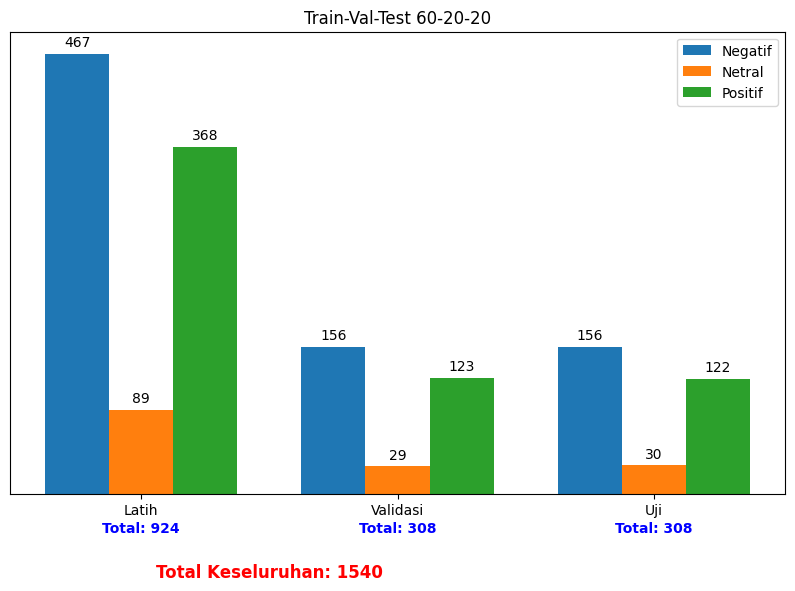

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Contoh data distribusi dari variabel
train_distribution = dict(zip(*np.unique(Y_train_with_index['sentiment_encoding'], return_counts=True)))
validation_distribution = dict(zip(*np.unique(Y_val_with_index['sentiment_encoding'], return_counts=True)))
testing_distribution = dict(zip(*np.unique(Y_test_with_index['sentiment_encoding'], return_counts=True)))

# Mapping dari encoding ke label deskriptif
label_mapping = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

# Menggunakan mapping untuk mengubah distribusi menjadi format deskriptif
train_distribution_mapped = {label_mapping[k]: v for k, v in train_distribution.items()}
validation_distribution_mapped = {label_mapping[k]: v for k, v in validation_distribution.items()}
testing_distribution_mapped = {label_mapping[k]: v for k, v in testing_distribution.items()}

# Extracting data and reformatting for grouped chart by dataset
datasets = ['Latih', 'Validasi', 'Uji']
negatif_counts = [train_distribution_mapped['Negatif'], validation_distribution_mapped['Negatif'], testing_distribution_mapped['Negatif']]
netral_counts = [train_distribution_mapped['Netral'], validation_distribution_mapped['Netral'], testing_distribution_mapped['Netral']]
positif_counts = [train_distribution_mapped['Positif'], validation_distribution_mapped['Positif'], testing_distribution_mapped['Positif']]

# Calculate total samples per dataset and overall total
total_counts_per_dataset = [sum([negatif_counts[i], netral_counts[i], positif_counts[i]]) for i in range(len(datasets))]
overall_total = sum(total_counts_per_dataset)

# Position of bars on x-axis
x = np.arange(len(datasets))

# Bar width
width = 0.25

# Plotting the bars grouped by dataset
fig, ax = plt.subplots(figsize=(10, 6))
bars_negatif = ax.bar(x - width, negatif_counts, width, label='Negatif')
bars_netral = ax.bar(x, netral_counts, width, label='Netral')
bars_positif = ax.bar(x + width, positif_counts, width, label='Positif')

# Adding labels, title, and legend
ax.set_title('Train-Val-Test 60-20-20')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Hiding y-axis
ax.yaxis.set_visible(False)

# Adding data labels to each bar
for bars in [bars_negatif, bars_netral, bars_positif]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset label above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adding total data labels below each group of bars
for i, total in enumerate(total_counts_per_dataset):
    ax.annotate(f'Total: {total}',
                xy=(x[i], 0),
                xytext=(0, -20),  # Offset below the bar group
                textcoords="offset points",
                ha='center', va='top', fontsize=10, fontweight='bold', color='blue')

# Adding overall total label at the bottom center
ax.annotate(f'Total Keseluruhan: {overall_total}',
            xy=(0.5, 0),
            xytext=(0, -50),  # Offset below the dataset totals
            textcoords="offset points",
            ha='center', va='top', fontsize=12, fontweight='bold', color='red', transform=ax.transAxes)

# Displaying the plot
plt.show()


In [ ]:
# import numpy as np

# # Menampilkan distribusi kelas sebelum dan sesudah oversampling
# print("Distribusi kelas:", dict(zip(*np.unique(Y_train_with_index['sentiment_encoding'], return_counts=True))))
# print("Distribusi kelas validasi:", dict(zip(*np.unique(Y_val_with_index['sentiment_encoding'], return_counts=True))))
# print("Distribusi kelas test:", dict(zip(*np.unique(Y_test_with_index['sentiment_encoding'], return_counts=True))))
# # One-hot encode labels
# Y_train = to_categorical(Y_train_with_index['sentiment_encoding'], num_classes=3)
# Y_val = to_categorical(Y_val_with_index['sentiment_encoding'], num_classes=3)
# Y_test = to_categorical(Y_test_with_index['sentiment_encoding'], num_classes=3)

Distribusi kelas: {0: 467, 1: 89, 2: 368}
Distribusi kelas validasi: {0: 156, 1: 29, 2: 123}
Distribusi kelas test: {0: 156, 1: 30, 2: 122}


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
negative,779
positive,613
neutral,148


In [ ]:
dict(zip(*np.unique(Y_with_index['sentiment_encoding'], return_counts=True)))

{0: 779, 1: 148, 2: 613}

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Flatten
from keras.optimizers import Adam
# Membuat model Sequential
model = Sequential()

model.add(Embedding(input_dim=total_words, output_dim=output_dim, input_length=max_sequence_length,
                    weights=[embedding_matrix], trainable=False))

model.add(LSTM(units=128, dropout=0.2, return_sequences=True)) # neuron 128 unit, Dropout dengan nilai 0.2
model.add(GlobalAveragePooling1D())  # Average pooling
model.add(Flatten())  # Flatten layer
model.add(Dense(units=64, activation='relu'))  # Hidden layer dengan fungsi aktivasi relu
model.add(Dense(units=3, activation='softmax'))  # Output layer dengan fungsi aktivasi softmax

# Mengatur optimizer Adam dengan learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Mengompilasi model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     138,637,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,637,500 (528.86 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 138,637,500 (528.86 MB)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint_path = root_path + 'saved_model/lstm_jogjakita/best_model_cbow_LSTM_jogjakita_non_upsampling_60_20_20.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1, save_weights_only=False)

# Melatih model
history = model.fit(X_train, Y_train, epochs=30, batch_size=256, validation_data=(X_val, Y_val), callbacks=[checkpoint])

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.4636 - loss: 1.0682
Epoch 1: val_accuracy improved from -inf to 0.50649, saving model to /content/gdrive/My Drive/KULIAH SEMESTER 8/KODING PENELITIAN SKRIPSI/saved_model/lstm_jogjakita/best_model_cbow_LSTM_jogjakita_non_upsampling_60_20_20.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.4681 - loss: 1.0639 - val_accuracy: 0.5065 - val_loss: 0.9599
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5087 - loss: 0.9324
Epoch 2: val_accuracy did not improve from 0.50649
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.5093 - loss: 0.9299 - val_accuracy: 0.5065 - val_loss: 0.8948
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5575 - loss: 0.8717
Epoch 3: val_accuracy improved from 0.50649 to 0.74675, saving model to /content/gdrive/My Drive/KULIAH SEMESTER 8/KODING PENELITIAN SKRIPSI/saved_model/lstm_jogjakita/best_model_cbow_LSTM_jogjakita_non_upsampling_60_20_20.keras
4/4 ━━━━━━━━━━

In [ ]:
import pickle

# Simpan history pelatihan
with open(root_path + 'saved_model/lstm_jogjakita/history_best_model_cbow_LSTM_jogjakita_non_upsampling_60_20_20', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

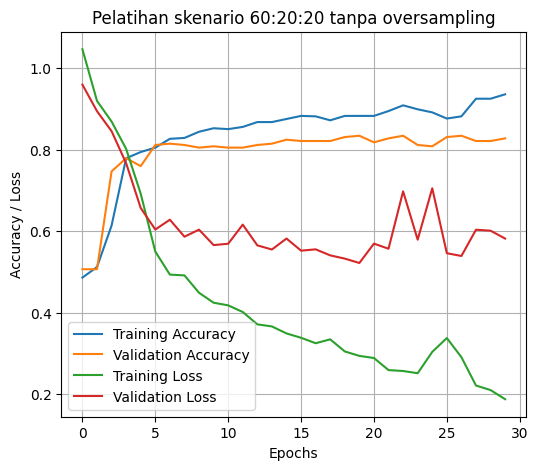

In [ ]:
import matplotlib.pyplot as plt

# ambil statistik pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(30)

# plot hasil akurasi dan loss pelatihan dalam satu grafik
plt.figure(figsize=(6, 5))

# Plot akurasi
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Plot loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.title('Pelatihan skenario 60:20:20 tanpa oversampling')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(root_path + 'saved_model/lstm_jogjakita/best_model_cbow_LSTM_jogjakita_non_upsampling_60_20_20.keras')

# Melihat ringkasan model (opsional)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 99, 300)             │     138,637,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 99, 128)             │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,321,799 (531.47 MB)

 Trainable params: 228,099 (891.01 KB)

 Non-trainable params: 138,637,500 (528.86 MB)

 Optimizer params: 456,200 (1.74 MB)

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns

# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Nilai Sebenarnya')
    plt.xlabel('Nilai Prediksi')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


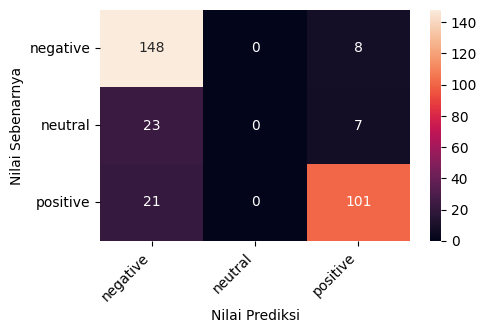

In [ ]:
# predict class with test set
y_pred_test = np.argmax(model.predict(X_test), axis=1)
y_true_test = np.argmax(Y_test, axis=1)

cm = confusion_matrix(y_true_test, y_pred_test)
print_confusion_matrix(cm, ['negative', 'neutral', 'positive'], figsize=(5, 3), fontsize=10)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def model_evaluate():
    # predict class with test set
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    y_true_test = np.argmax(Y_test, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_true_test, y_pred_test)
    print('Accuracy:\t{:0.2f}%'.format(accuracy * 100))

    # Lists to store metrics for each class
    precisions = []
    recalls = []
    f1_scores = []

    # Calculate metrics for each class
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        precision = precision_score(y_true_test, y_pred_test, average=None, labels=[i])[0]
        recall = recall_score(y_true_test, y_pred_test, average=None, labels=[i])[0]
        f1 = f1_score(y_true_test, y_pred_test, average=None, labels=[i])[0]

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f'\nSentimen {sentiment}:')
        print('Precision:\t{:0.2f}%'.format(precision * 100))
        print('Recall:\t\t{:0.2f}%'.format(recall * 100))
        print('F1-Score:\t{:0.2f}%'.format(f1 * 100))

    # Calculate macro average metrics
    precision_average = precision_score(y_true_test, y_pred_test, average='macro')
    recall_average = recall_score(y_true_test, y_pred_test, average='macro')
    f1_average = f1_score(y_true_test, y_pred_test, average='macro')

    print('\nRata-rata')
    print('Precision:\t{:0.2f}%'.format(precision_average * 100))
    print('Recall:\t\t{:0.2f}%'.format(recall_average * 100))
    print('F1-Score:\t{:0.2f}%'.format(f1_average * 100))

    # Classification report
    print('\nClassification Report:\n')
    print(classification_report(y_true_test, y_pred_test))

In [ ]:
model_evaluate()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Accuracy:	80.84%

Sentimen Negative:
Precision:	77.08%
Recall:		94.87%
F1-Score:	85.06%

Sentimen Neutral:
Precision:	0.00%
Recall:		0.00%
F1-Score:	0.00%

Sentimen Positive:
Precision:	87.07%
Recall:		82.79%
F1-Score:	84.87%

Rata-rata
Precision:	54.72%
Recall:		59.22%
F1-Score:	56.64%

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       156
           1       0.00      0.00      0.00        30
           2       0.87      0.83      0.85       122

    accuracy                           0.81       308
   macro avg       0.55      0.59      0.57       308
weighted avg       0.74      0.81      0.77       308



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWa